In [1]:
%load_ext autoreload
%autoreload 2
import os 
os.environ["HF_HOME"] = "/tmp/wendler/hf_cache"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import sys
sys.path.append('/share/u/wendler/code/my-sdxl-unbox')

In [2]:
n = 10
path_to_checkpoints = '../hparam_study/'#'../checkpoints/'#'../hparam_study/'
k = 160
exp = 4
n_timesteps = 20
use_vanilla = True
cfg_idx = 1

In [3]:
if use_vanilla == False:
    assert cfg_idx == 0, "cfg_idx must be 0 if use_vanilla is False"
else:
    assert cfg_idx==0 or cfg_idx == 1, "cfg_idx must be 0 or 1 if use_vanilla is True"

In [4]:
outfile = f"timestep_generalization_n{n}_t{n_timesteps}_{'vanilla' if use_vanilla else 'turbo'}_k{k}_exp{exp}_cfgidx{cfg_idx}.csv"

In [5]:
n_feats = exp * 1280

In [6]:
import os
import gradio as gr
import torch
from SDLens import HookedStableDiffusionXLPipeline
from SAE import SparseAutoencoder
from app import create_demo
assert torch.cuda.is_available(), "Your machine has no access to GPU. If you are using Colab, consider changing environment"
# The SAEs were trained to work with torch.float32, but they can also work with torch.float16
# Change this value to torch.float32 if you have access to a GPU with >30GB of memory
dtype=torch.float16
dtype=torch.float32

sdxl_turbo = "stabilityai/sdxl-turbo" 
sdxl = "stabilityai/stable-diffusion-xl-base-1.0"
if not use_vanilla:
    model_name = sdxl_turbo 
else:
    model_name = sdxl

pipe = HookedStableDiffusionXLPipeline.from_pretrained(
    model_name,
    torch_dtype=dtype,
    device_map="balanced",
    variant=("fp16" if dtype==torch.float16 else None)
)
pipe.set_progress_bar_config(disable=True)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [7]:
code_to_block = {
    "down.2.1": "unet.down_blocks.2.attentions.1",
    "mid.0": "unet.mid_block.attentions.0",
    "up.0.1": "unet.up_blocks.0.attentions.1",
    "up.0.0": "unet.up_blocks.0.attentions.0"
}

saes_dict = {}
means_dict = {}

for code, block in code_to_block.items():
    sae = SparseAutoencoder.load_from_disk(
        os.path.join(path_to_checkpoints, f"{block}_k{k}_hidden{n_feats}_auxk256_bs4096_lr0.0001", "final"),
    )
    saes_dict[code] = sae.to('cuda', dtype=dtype)

In [8]:
import numpy as np
from matplotlib import pyplot as plt
import json
if n > 5:
    with open('/tmp/wendler/first_50K_prompts.json', 'r') as f:
        prompts = json.load(f)
    prompts = [p["caption"] for p in prompts[:n]]
else:
    prompts = [
        "A photo of a cat",
        "A photo of a dog",
        "A photo of a bird",
        "A photo of a fish",
        "A photo of a horse",
    ]

In [9]:
prompts

['The Ferrari GTS is driving down the street.',
 'An antique chandelier with five lights.',
 'Three men in suits and hats standing next to each other.',
 'A man in a fur vest and hat holding a microphone.',
 'A couple is standing in the water at sunset.',
 'A man in glasses and suit speaking into a microphone.',
 'An older man and woman are looking at something.',
 'The white truck is parked in the parking lot.',
 'A woman wearing a black hat with a large bow.',
 'Three little remedies for kids: saline spray.']

In [10]:
# find out the models inside of pipe
if dtype == torch.float32:
    pipe.text_encoder.to(dtype=torch.float32)
    pipe.text_encoder_2.to(dtype=torch.float32)

In [11]:
from collections import defaultdict


In [12]:
sys.path.append('/share/u/wendler/code/my-sdxl-unbox/scripts')
from train_sae import explained_variance
from tqdm import tqdm
from einops import einsum, rearrange
verbose = False
results = defaultdict(list)
for pidx, prompt in enumerate(tqdm(prompts)):
    output, cache = pipe.run_with_cache(
        prompt,
        positions_to_cache=list(code_to_block.values()),
        save_input=True,
        save_output=True,
        num_inference_steps=n_timesteps,
        guidance_scale=0.0 if not use_vanilla else 7.5,
        generator=torch.Generator(device="cpu").manual_seed(42)
    )
    timesteps = pipe.scheduler.timesteps
    if verbose:
        plt.imshow(output.images[0])
        plt.show()
    for short, long in code_to_block.items():
        for cfg_idx in range(cache['output'][long].shape[0]):
            #print(cache['output'][long].shape)
            diff = cache['output'][long][cfg_idx] - cache['input'][long][cfg_idx]
            # timesteps x features x height x width
            #gprint(short, sae.path)
            sae = saes_dict[short]
            diff_perm = diff.permute(0, 2, 3, 1) # 
            # timesteps x height x width x features
            diff_flat = diff_perm.reshape(-1, diff.shape[1])
            # (timesteps * height * width) x features
            recon, info = sae(diff_flat)
            # (timesteps * height * width) x features

            features = sae.encode(diff_perm)
            # timesteps x height x width x features
            fnormalized = features / features.norm(dim=-1, keepdim=True)
            dnormalized = diff_perm / diff_perm.norm(dim=-1, keepdim=True)
            fbinarized = (features > 0).float()
            fdots = einsum(fnormalized[:-1], fnormalized[1:], "t h w f, t h w f -> t h w").mean(dim=1).mean(dim=1)
            dots = einsum(dnormalized[:-1], dnormalized[1:], "t h w f, t h w f -> t h w").mean(dim=1).mean(dim=1)
            fdots_binarized = einsum(fbinarized[:-1], fbinarized[1:], "t h w f, t h w f -> t h w") # == intersection 
            # union next
            fdots_union = (fbinarized[:-1] + fbinarized[1:]).clamp(0, 1).sum(dim=-1)
            iou = fdots_binarized / fdots_union
            iou_mean = iou.mean(dim=1).mean(dim=1)
            # then .mean(dim=1).mean(dim=1)
            
            recon = recon.reshape(len(timesteps), -1, recon.shape[1]) # this guy breaks things
            # timesteps x (height * width) x features
            for idx in range(diff.shape[0]):
                tmp = diff[idx].permute(1,2,0).reshape(-1, diff_flat.shape[1])
                mse2 = ((recon[idx] - tmp)**2).mean()
                # expects n x features
                explained_var = explained_variance(diff[idx].permute(1,2,0).reshape(-1, diff.shape[1]), recon[idx])
                if cfg_idx == 0:
                    results["block"].append(short)
                    #results["prompt"].append(prompt)
                    results["tidx"].append(idx)
                    results["t"].append(timesteps[idx].item())
                results[f"mse_{cfg_idx}"].append(mse2.item())
                results[f"explained_var_{cfg_idx}"].append(explained_var.item())
                if idx == diff.shape[0] - 1:
                    results[f"fdots_{cfg_idx}"].append(0.0)
                    results[f"dots_{cfg_idx}"].append(0.0)
                    results[f"iou_{cfg_idx}"].append(0.0)
                else:
                    results[f"fdots_{cfg_idx}"].append(fdots[idx].item())
                    results[f"dots_{cfg_idx}"].append(dots[idx].item())
                    results[f"iou_{cfg_idx}"].append(iou_mean[idx].item())
from pandas import DataFrame
df = DataFrame(results)
df.to_csv(outfile)
df

100%|██████████| 10/10 [02:57<00:00, 17.74s/it]


,block,tidx,t,mse_0,explained_var_0,fdots_0,dots_0,iou_0,mse_1,explained_var_1,fdots_1,dots_1,iou_1
0,down.2.1,0,951.0,0.511309,0.740449,0.629847,0.555715,0.352232,0.562675,0.816745,0.804277,0.815341,0.489406
1,down.2.1,1,901.0,0.529848,0.737794,0.759903,0.747039,0.454353,0.606251,0.811523,0.861153,0.874171,0.579635
2,down.2.1,2,851.0,0.583199,0.767847,0.900139,0.912997,0.635449,0.645868,0.796499,0.940707,0.953552,0.725747
3,down.2.1,3,801.0,0.624115,0.774912,0.909173,0.922490,0.652583,0.682203,0.790681,0.938532,0.952265,0.720591
4,down.2.1,4,751.0,0.661150,0.773274,0.906153,0.919919,0.646112,0.727182,0.783230,0.935441,0.949996,0.711119
...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,up.0.0,15,201.0,2.249230,0.840494,0.976020,0.990466,0.832956,2.354433,0.839181,0.975922,0.990703,0.833941
796,up.0.0,16,151.0,2.311046,0.835815,0.970129,0.987501,0.816208,2.412444,0.834554,0.969947,0.987453,0.817677
797,up.0.0,17,101.0,2.368528,0.828661,0.952214,0.979114,0.765043,2.464864,0.827897,0.952668,0.979957,0.766578
798,up.0.0,18,51.0,2.411909,0.817940,0.771515,0.836232,0.468112,2.508281,0.817337,0.775410,0.842102,0.473198


In [13]:
df

,block,tidx,t,mse_0,explained_var_0,fdots_0,dots_0,iou_0,mse_1,explained_var_1,fdots_1,dots_1,iou_1
0,down.2.1,0,951.0,0.511309,0.740449,0.629847,0.555715,0.352232,0.562675,0.816745,0.804277,0.815341,0.489406
1,down.2.1,1,901.0,0.529848,0.737794,0.759903,0.747039,0.454353,0.606251,0.811523,0.861153,0.874171,0.579635
2,down.2.1,2,851.0,0.583199,0.767847,0.900139,0.912997,0.635449,0.645868,0.796499,0.940707,0.953552,0.725747
3,down.2.1,3,801.0,0.624115,0.774912,0.909173,0.922490,0.652583,0.682203,0.790681,0.938532,0.952265,0.720591
4,down.2.1,4,751.0,0.661150,0.773274,0.906153,0.919919,0.646112,0.727182,0.783230,0.935441,0.949996,0.711119
...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,up.0.0,15,201.0,2.249230,0.840494,0.976020,0.990466,0.832956,2.354433,0.839181,0.975922,0.990703,0.833941
796,up.0.0,16,151.0,2.311046,0.835815,0.970129,0.987501,0.816208,2.412444,0.834554,0.969947,0.987453,0.817677
797,up.0.0,17,101.0,2.368528,0.828661,0.952214,0.979114,0.765043,2.464864,0.827897,0.952668,0.979957,0.766578
798,up.0.0,18,51.0,2.411909,0.817940,0.771515,0.836232,0.468112,2.508281,0.817337,0.775410,0.842102,0.473198


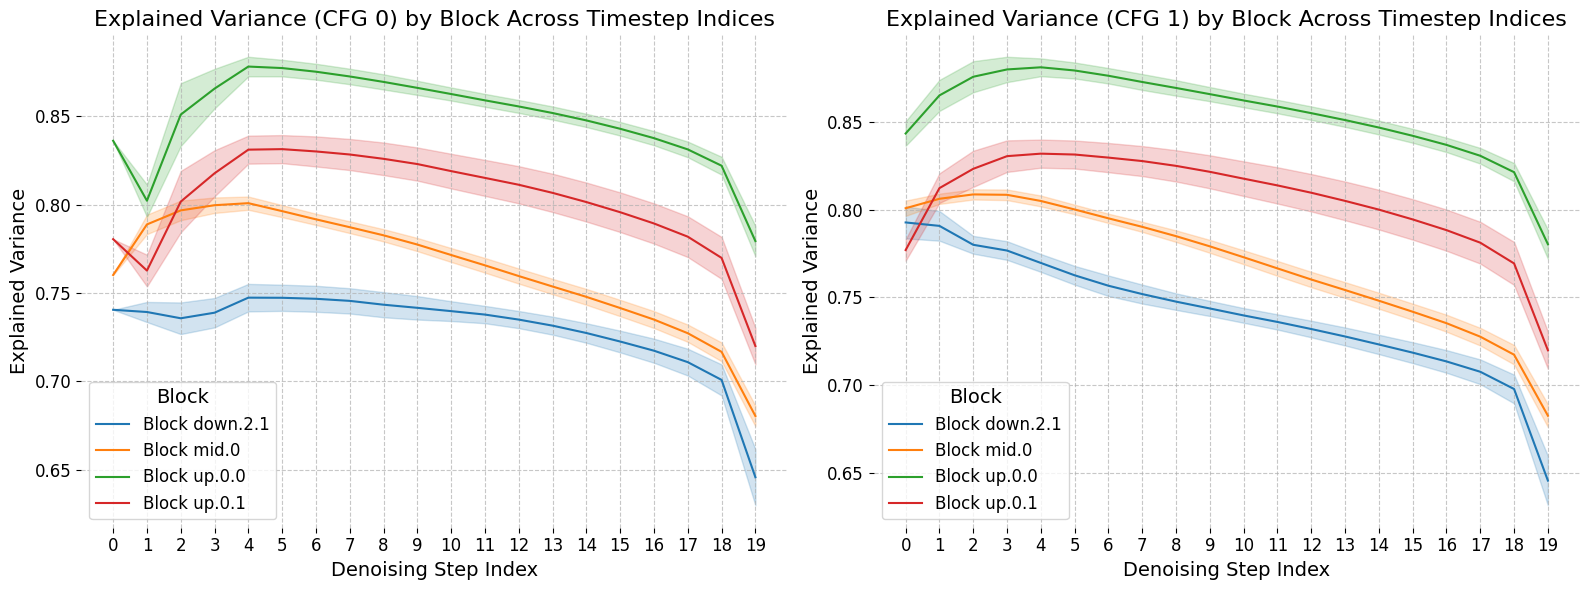

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create a figure with subplots for each cfg_idx
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Get the number of cfg indices
cfg_indices = [0, 1]  # Assuming we have cfg_idx 0 and 1

for cfg_idx, ax in zip(cfg_indices, axes):
    # Group by block and tidx to get mean and std of explained variance for this cfg_idx
    var_col = f"explained_var_{cfg_idx}"
    summary_df = df.groupby(["block", "tidx"])[var_col].agg(['mean', 'std']).reset_index()
    
    # Remove border
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    blocks = summary_df['block'].unique()
    colors = sns.color_palette(n_colors=len(blocks))
    
    for i, block in enumerate(blocks):
        block_df = summary_df[summary_df['block'] == block]
        ax.plot(block_df['tidx'], block_df['mean'], label=f"Block {block}", color=colors[i])
        # Gaussian confidence interval: mean ± 1.96*std
        lower = block_df['mean'] - 1.96 * block_df['std']/np.sqrt(len(block_df))
        upper = block_df['mean'] + 1.96 * block_df['std']/np.sqrt(len(block_df))
        ax.fill_between(block_df['tidx'], lower, upper, color=colors[i], alpha=0.2)
    
    # Add gridlines
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Increase font size
    ax.set_title(f"Explained Variance (CFG {cfg_idx}) by Block Across Timestep Indices", fontsize=16)
    ax.set_xlabel("Denoising Step Index", fontsize=14)
    ax.set_ylabel("Explained Variance", fontsize=14)
    ax.legend(title="Block", loc='lower left', fontsize=12, title_fontsize=14)
    # they should be just 1 apart
    ax.set_xticks(block_df['tidx'])
    ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()

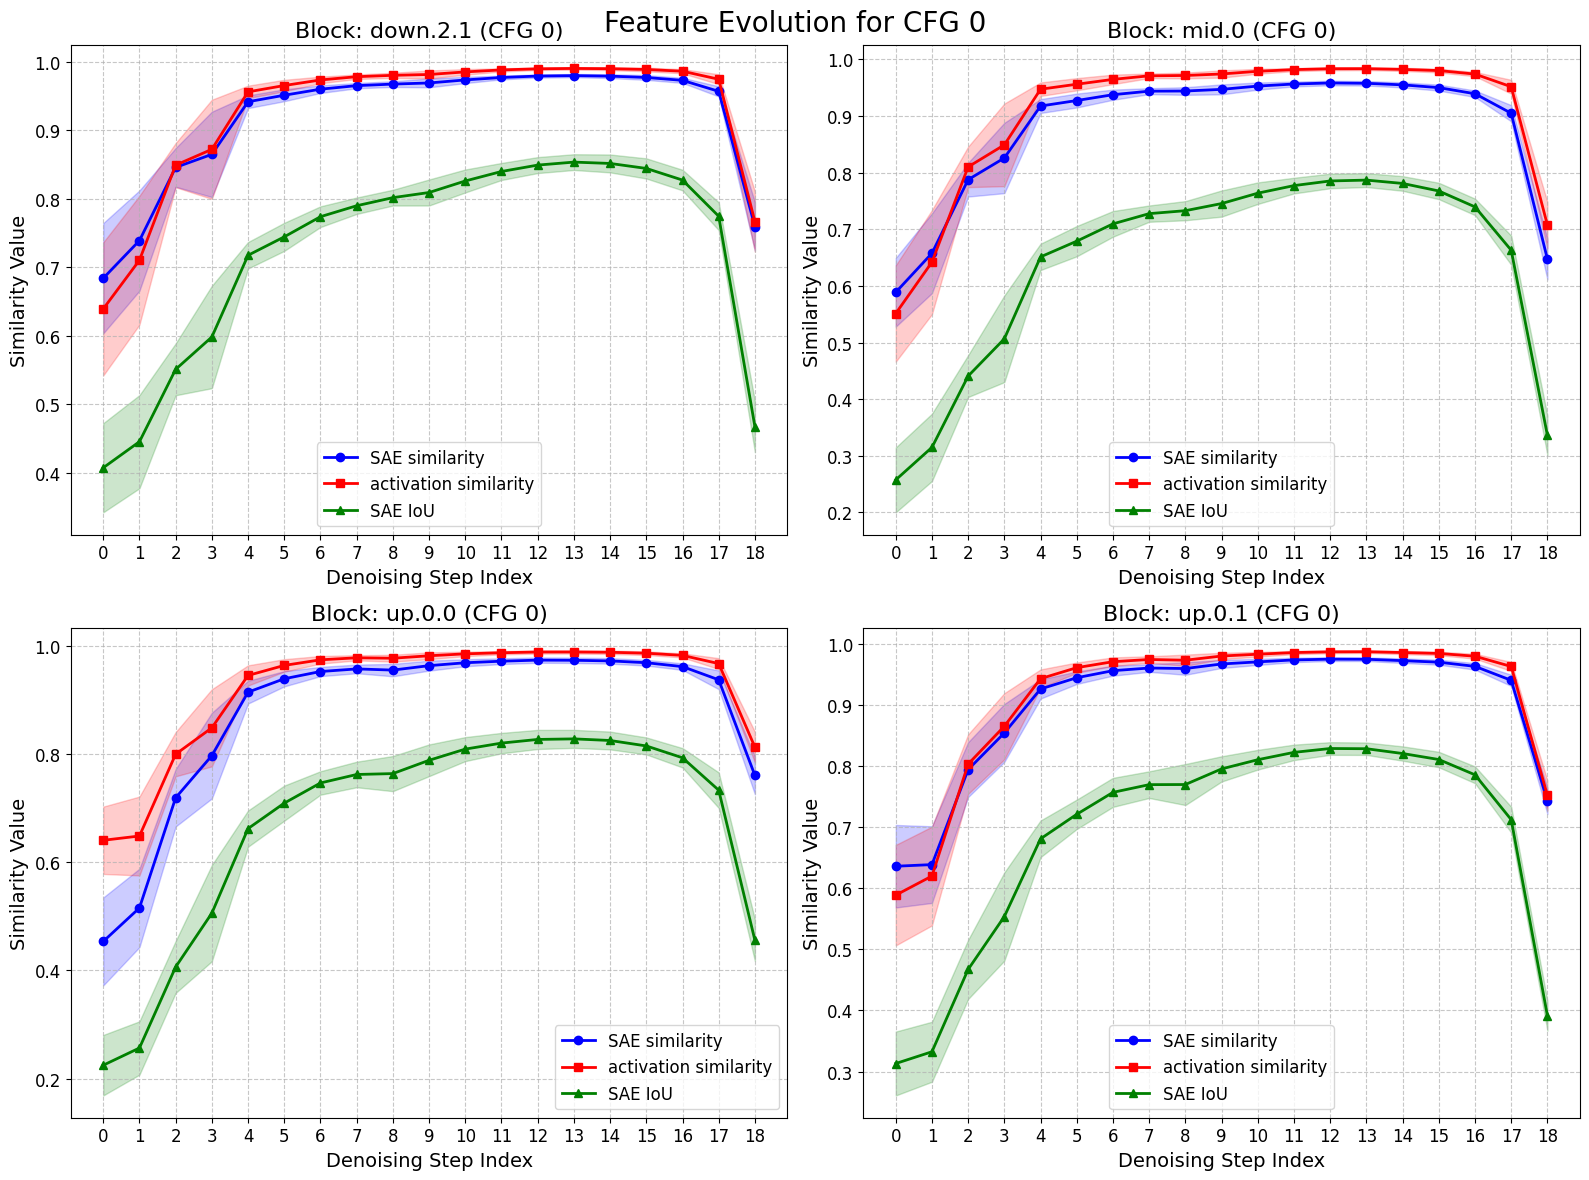

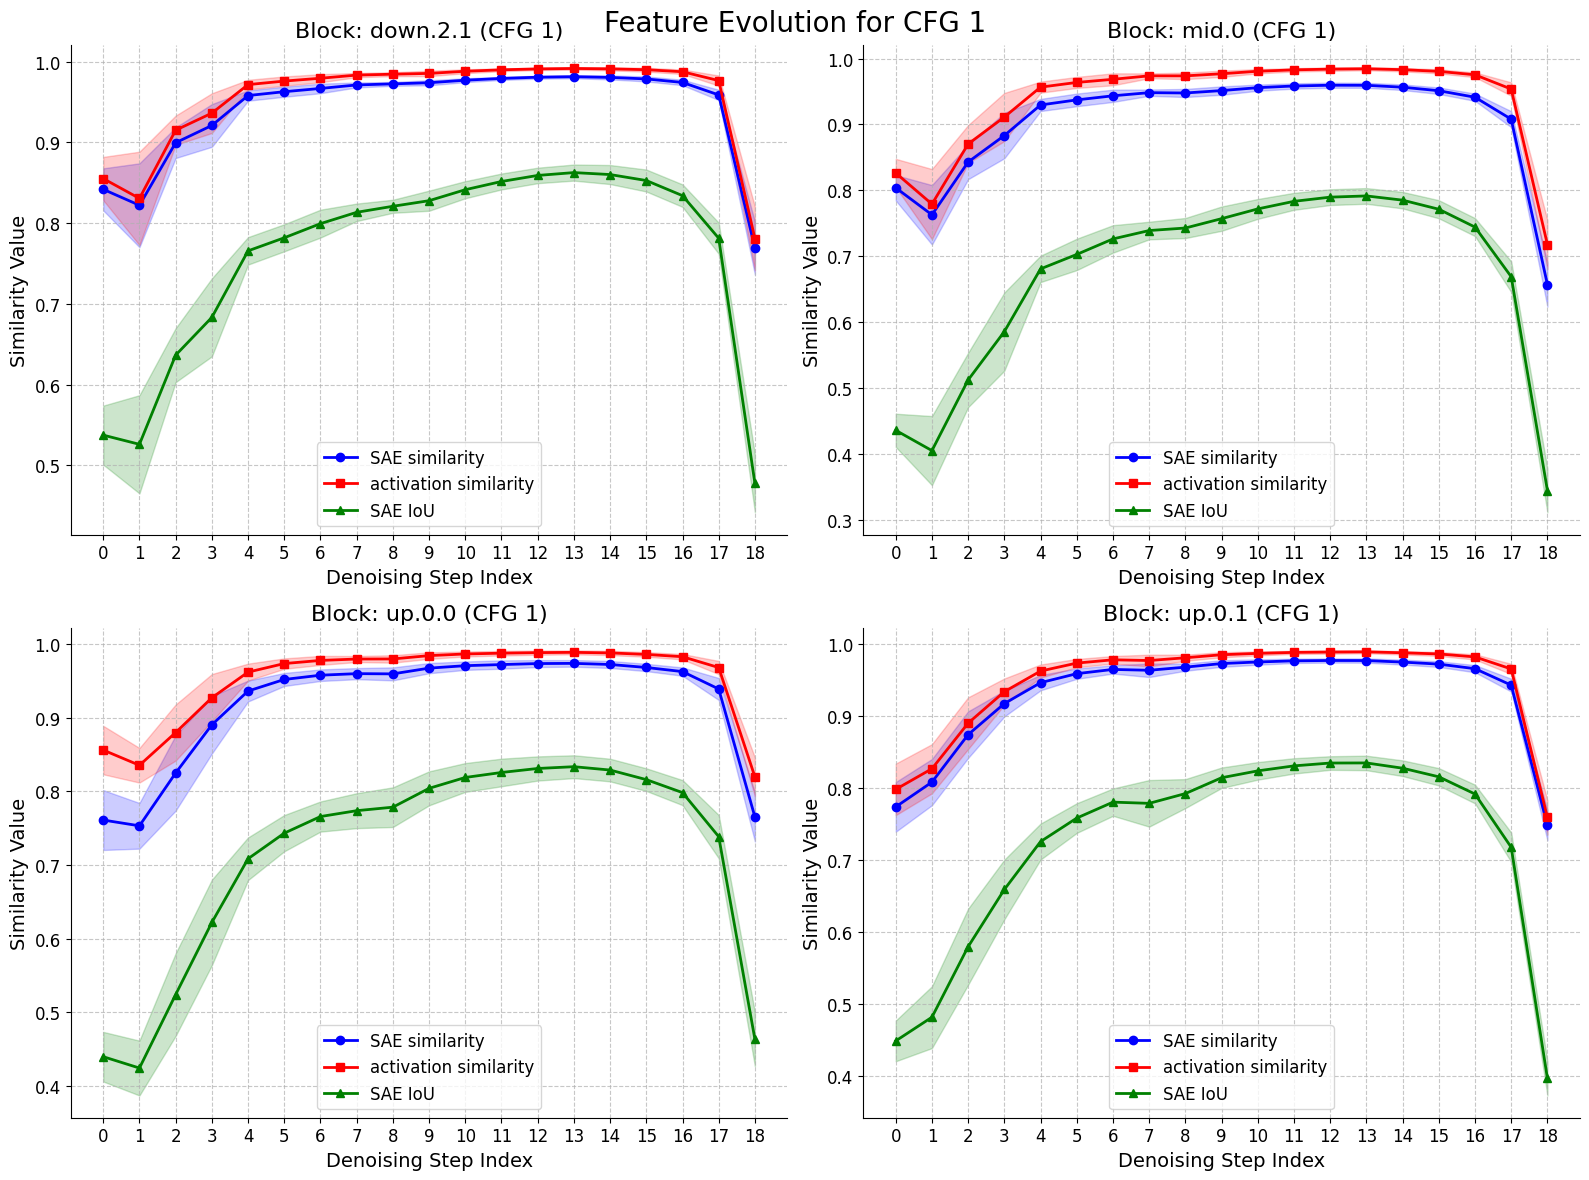

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get unique block names
block_types = sorted(df['block'].unique())

# Get the number of cfg indices
cfg_indices = [0, 1]  # Assuming we have cfg_idx 0 and 1

for cfg_idx in cfg_indices:
    # Create a grid of subplots for this cfg_idx
    n_blocks = len(block_types)
    n_cols = 2
    n_rows = (n_blocks + n_cols - 1) // n_cols  # Ceiling division
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 12))
    axes = axes.flatten()
    
    # Set common style parameters
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.right'] = False
    
    # Colors for different metrics
    colors = {'fdots': 'blue', 'dots': 'red', 'fdots_binarized': 'green'}
    
    for i, block_type in enumerate(block_types):
        if i >= len(axes):
            break
            
        # Filter data for this block type and cfg_idx
        block_data = df[df['block'] == block_type]
        
        # Group by tidx to get mean values
        tidx_groups = block_data.groupby('tidx')
        
        # Get unique tidx values and sort them, excluding the last datapoint which is a placeholder
        tidx_values = sorted(block_data['tidx'].unique())[:-1]  # Remove the last tidx (placeholder)
        
        # Get mean and std values for each tidx and metric, excluding the placeholder
        fdots_col = f"fdots_{cfg_idx}"
        dots_col = f"dots_{cfg_idx}"
        fdots_binarized_col = f"iou_{cfg_idx}"
        
        mean_fdots = [tidx_groups.get_group(tidx)[fdots_col].mean() for tidx in tidx_values]
        std_fdots = [tidx_groups.get_group(tidx)[fdots_col].std() / np.sqrt(len(tidx_groups.get_group(tidx))) for tidx in tidx_values]
        
        mean_dots = [tidx_groups.get_group(tidx)[dots_col].mean() for tidx in tidx_values]
        std_dots = [tidx_groups.get_group(tidx)[dots_col].std() / np.sqrt(len(tidx_groups.get_group(tidx))) for tidx in tidx_values]
        
        mean_fdots_binarized = [tidx_groups.get_group(tidx)[fdots_binarized_col].mean() for tidx in tidx_values]
        std_fdots_binarized = [tidx_groups.get_group(tidx)[fdots_binarized_col].std() / np.sqrt(len(tidx_groups.get_group(tidx))) for tidx in tidx_values]
        
        # Plot all three metrics with confidence intervals
        axes[i].plot(tidx_values, mean_fdots, 'o-', label='SAE similarity', linewidth=2, color=colors['fdots'])
        # Add Gaussian confidence interval: mean ± 1.96*std_error
        axes[i].fill_between(tidx_values, 
                             [m - 1.96*s for m, s in zip(mean_fdots, std_fdots)], 
                             [m + 1.96*s for m, s in zip(mean_fdots, std_fdots)], 
                             color=colors['fdots'], alpha=0.2)
        
        axes[i].plot(tidx_values, mean_dots, 's-', label='activation similarity', linewidth=2, color=colors['dots'])
        axes[i].fill_between(tidx_values, 
                             [m - 1.96*s for m, s in zip(mean_dots, std_dots)], 
                             [m + 1.96*s for m, s in zip(mean_dots, std_dots)], 
                             color=colors['dots'], alpha=0.2)
        
        # Add a second y-axis for fdots_binarized if the scale is very different
        if max(mean_fdots_binarized) > 5 * max(mean_fdots):
            ax2 = axes[i].twinx()
            ax2.plot(tidx_values, mean_fdots_binarized, '^-', label='SAE IoU', linewidth=2, color=colors['fdots_binarized'])
            ax2.fill_between(tidx_values, 
                             [m - 1.96*s for m, s in zip(mean_fdots_binarized, std_fdots_binarized)], 
                             [m + 1.96*s for m, s in zip(mean_fdots_binarized, std_fdots_binarized)], 
                             color=colors['fdots_binarized'], alpha=0.2)
            ax2.set_ylabel('FDots Binarized Value', fontsize=14, color=colors['fdots_binarized'])
            ax2.tick_params(axis='y', labelcolor=colors['fdots_binarized'])
            # Don't plot fdots_binarized on the first axis if we're using a second axis
        else:
            # Only plot on the first axis if we're not using a second axis
            axes[i].plot(tidx_values, mean_fdots_binarized, '^-', label='SAE IoU', linewidth=2, color=colors['fdots_binarized'])
            axes[i].fill_between(tidx_values, 
                                 [m - 1.96*s for m, s in zip(mean_fdots_binarized, std_fdots_binarized)], 
                                 [m + 1.96*s for m, s in zip(mean_fdots_binarized, std_fdots_binarized)], 
                                 color=colors['fdots_binarized'], alpha=0.2)
            
        # Add labels and title
        axes[i].set_title(f"Block: {block_type} (CFG {cfg_idx})", fontsize=16)
        axes[i].set_xlabel("Denoising Step Index", fontsize=14)
        axes[i].set_ylabel("Similarity Value", fontsize=14)
        axes[i].grid(True, linestyle='--', alpha=0.7)
        axes[i].legend(fontsize=12)
        axes[i].tick_params(axis='both', which='major', labelsize=12)
        
        # Set x-ticks to be exactly at the timestep indices
        axes[i].set_xticks(tidx_values)
    
    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.suptitle(f"Feature Evolution for CFG {cfg_idx}", fontsize=20)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Make room for the suptitle
    plt.show()

In [16]:
sae.k

160